# Web Scraping

Imports

In [58]:
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import re
import os
import pymysql
from sqlalchemy import create_engine

Set Up Working Directory

In [59]:
os.chdir('/Users/christopher/Desktop/IronHack/Projects')

In [60]:
os.listdir()

['Web Scraping.ipynb',
 'Game_df.csv',
 'SharkPipeline.py',
 'WebScraping.py',
 '.ipynb_checkpoints',
 'Game_df']

A. Collect Genre from All Games - Website @ game.co.uk and create a database of Genre and # of games for each

In [8]:
# Get soup - and define url of genre website
url = 'https://www.game.co.uk/en/games/?attributeName1=Release%20Date&sortColumn=popular&sortTypeStr=DESC&inStockOnly=true&listerOnly=true&attributeValue1=4294965823&sortBy='

html = requests.get(url).content

soup = BeautifulSoup(html,'lxml')

# Get only genre list and #
# div.genre a to select genre div. a has text of genre and span contains the number of games in that genre

genre_list=[i.text.strip().replace('\xa0','.') for i in soup.select('div.genre a')]
# To find website forward links, save all numbers in url linked to genre page
genre_web_page = [re.findall(r'2=(\d+)',i['href']) for i in soup.select('div.genre a')]

genre_web_page_flat = []
# Turn web page numbers into ints
for i in genre_web_page:
    for x in i:
        genre_web_page_flat.append(int(x))

print (genre_web_page_flat)


[4294964372, 4294963533, 4294965800, 4294965775, 4294965820, 4294965792, 4294963551, 4294963086, 4294963563, 4294965812, 4294965633, 4294952416, 4294957336, 4294965634, 4294956397, 4294945536, 4294965770, 4294965683, 4294965832, 4294965567, 4294965667, 4294963555, 4294965703, 4294952866, 4294952522, 4294964352, 4294965534, 4294952867, 4294957642, 4294965744, 4294963586, 4294965702, 4294965487, 4294954330, 4294948814, 4294945535, 4294956395, 4294965581, 4294965831, 4294965756, 4294965547, 4294963542, 4294963541, 4294964357, 4294965730, 4294957700, 4294963558, 4294948398, 4294965768, 4294965786, 4294965806, 4294965824, 4294963650, 4294957667, 4294952868, 4294965819, 4294963532, 4294965764, 4294963540, 4294957620, 4294965788, 4294965815, 4294963621, 4294965778, 4294957617, 4294947918, 4294963548, 4294957669]


In [4]:
# Create a dataframe from genre, with columns = genre, rows = number of games in genre
Genre_DataFrame = pd.DataFrame([i.split('.') for i in genre_list], columns=['Genre','Number'])
# Clean number colums
Genre_DataFrame.Number = Genre_DataFrame.Number.str.strip(')(')
Genre_DataFrame.Number = Genre_DataFrame.Number.str.replace(',','')
Genre_DataFrame.Number = pd.to_numeric(Genre_DataFrame.Number)
# add Genre web link to df
Genre_DataFrame['Web'] = genre_web_page_flat

# Export database to mysql


In [5]:
Genre_DataFrame

,Genre,Number,Web
0,100,1,4294964372
1,3XL,1,4294963533
2,Accessories,353,4294965800
3,Action,2,4294965775
4,Action/Adventure,4382,4294965820
...,...,...,...
63,Toys and Gadgets,58,4294965778
64,Trading Cards,10,4294957617
65,VR Headsets,2,4294947918
66,XL,2,4294963548


In [33]:
engine = create_engine('mysql+pymysql://root:{}')
Genre_DataFrame.to_sql(name='Genre', con=engine, if_exists = 'append')

B. Find top 10 genres from df, and loop through and locate 5 web pages from that genre

In [226]:
# Sort based on number of games in each genre
# df.sort_values('Number', ascending=False, inplace=True)
# Loop through genre and get the top 10 genres, make a list of these
# replace value 2
# for each url, scrape 5 websites

https://www.game.co.uk/en/games/?attributeName1=Release%20Date&sortColumn=popular&sortTypeStr=DESC&inStockOnly=true&listerOnly=true&attributeValue2=4294965820&attributeValue1=4294965823&sortBy=&attributeName2=Genre&pageSize=96&pageNumber=1
https://www.game.co.uk/en/games/?attributeName1=Release%20Date&sortColumn=popular&sortTypeStr=DESC&inStockOnly=true&listerOnly=true&attributeValue2=4294965820&attributeValue1=4294965823&sortBy=&attributeName2=Genre&pageSize=96&pageNumber=2
https://www.game.co.uk/en/games/?attributeName1=Release%20Date&sortColumn=popular&sortTypeStr=DESC&inStockOnly=true&listerOnly=true&attributeValue2=4294965820&attributeValue1=4294965823&sortBy=&attributeName2=Genre&pageSize=96&pageNumber=3
https://www.game.co.uk/en/games/?attributeName1=Release%20Date&sortColumn=popular&sortTypeStr=DESC&inStockOnly=true&listerOnly=true&attributeValue2=4294965820&attributeValue1=4294965823&sortBy=&attributeName2=Genre&pageSize=96&pageNumber=4
https://www.game.co.uk/en/games/?attribu

In [6]:
# sort by most popular genre
Genre_DataFrame.sort_values(by='Number', ascending=False, inplace=True)
Genre_DataFrame.head(10)

,Genre,Number,Web
4,Action/Adventure,4382,4294965820
27,Family/Casual,1689,4294952867
60,Sport,1438,4294965788
55,Shooter,1314,4294965819
50,Racing,966,4294965806
54,RPG,960,4294952868
5,Activity,671,4294965792
61,Strategy,558,4294965815
49,Puzzle,526,4294965786
57,Simulation,515,4294965764


In [7]:
# New database with only top 10 most popular genres
Genre_DataFrame_10 = Genre_DataFrame.head(10)
Genre_DataFrame_10

,Genre,Number,Web
4,Action/Adventure,4382,4294965820
27,Family/Casual,1689,4294952867
60,Sport,1438,4294965788
55,Shooter,1314,4294965819
50,Racing,966,4294965806
54,RPG,960,4294952868
5,Activity,671,4294965792
61,Strategy,558,4294965815
49,Puzzle,526,4294965786
57,Simulation,515,4294965764


In [9]:
# Create df of games
Game_df = pd.DataFrame()
# Get data on one page before looping
for genre,web in zip(Genre_DataFrame_10.Genre, Genre_DataFrame_10.Web):
    for k in range(1,len(Genre_DataFrame_10)):
        url = f'https://www.game.co.uk/en/games/?attributeName1=Release%20Date&sortColumn=popular&sortTypeStr=DESC&inStockOnly=true&listerOnly=true&attributeValue2={web}&attributeValue1=4294965823&sortBy=&attributeName2=Genre&pageSize=96&pageNumber={k}'
        html = requests.get(url).content
        soup = BeautifulSoup(html,'lxml')
        # All information I need per article
        Name = [i.text for i in soup.select('article.product h2>a')]
        New_Price = [0 if i.find('div', {'class':'priceContainer'}).find('a',{'class':'mintPrice'}) is None else float(i.find('div', {'class':'priceContainer'}).find('a',{'class':'mintPrice'}).find('span').text[1:].replace(',','')) for i in soup.find_all('article',{'class': 'product'})]
        Preowned_Price = [0 if i.find('div', {'class':'priceContainer'}).find('a',{'class':'preownedPrice'}) is None else float(i.find('div', {'class':'priceContainer'}).find('a',{'class':'preownedPrice'}).find('span').text[1:].replace(',','')) for i in soup.find_all('article',{'class': 'product'})]
        Download_Price = [0 if i.find('div', {'class':'priceContainer'}).find('a',{'class':['preownedPrice','downloadPrice']}) is None else float(i.find('div', {'class':'priceContainer'}).find('a',{'class':['preownedPrice','downloadPrice']}).find('span').text[1:].replace(',','')) for i in soup.find_all('article',{'class': 'product'})]
        Other_Price = [0 if i.find('div', {'class':'priceContainer'}).find('a',{'class':'other'}) is None else float(i.find('div', {'class':'priceContainer'}).find('a',{'class':'other'}).find('span').text[1:].replace(',','')) for i in soup.find_all('article',{'class': 'product'})]
        Console = [i.text.strip() for i in soup.select('article.product>div.productHeader>span.platformLogo')]
        df = pd.DataFrame()
        df['Name'] = Name
        df['New_Price'] = New_Price
        df['Preowned_Price'] = Preowned_Price
        df['Download_Price'] = Download_Price
        df['Other_Price'] = Other_Price
        df['Console'] = Console
        df['Genre'] = genre
        Game_df = Game_df.append(df)
Game_df

,Name,New_Price,Preowned_Price,Download_Price,Other_Price,Console,Genre
0,Marvel's Spider-Man - The Only on PlayStation ...,29.99,24.99,24.99,39.88,(PlayStation 4),Action/Adventure
1,Death Stranding,49.99,39.99,39.99,41.90,(PlayStation 4),Action/Adventure
2,Star Wars Jedi: Fallen Order,49.99,42.99,42.99,42.85,(PlayStation 4),Action/Adventure
3,Star Wars Jedi: Fallen Order,49.99,0.00,0.00,41.85,(Xbox One),Action/Adventure
4,Pokemon Sword or Shield Expansion Pass,0.00,29.99,29.99,0.00,(Switch),Action/Adventure
...,...,...,...,...,...,...,...
30,Comet Jetliner,19.64,0.00,0.00,0.00,(PC),Simulation
31,The Sims 2 Teen Style Stuff,0.00,8.99,8.99,0.00,(PC),Simulation
32,Hakuoki: Memories of the Shinsengumi Limited E...,39.99,0.00,0.00,0.00,(2DS/3DS),Simulation
33,The Unicorn Princess,33.60,0.00,0.00,0.00,(PlayStation 4),Simulation


In [10]:
# clean up Console column 
Game_df.Console = Game_df.Console.str.strip(')(')
# Reset index if needed, inplace =save and drop = drops old index
Game_df.reset_index(inplace=True, drop=True)
Game_df

,Name,New_Price,Preowned_Price,Download_Price,Other_Price,Console,Genre
0,Marvel's Spider-Man - The Only on PlayStation ...,29.99,24.99,24.99,39.88,PlayStation 4,Action/Adventure
1,Death Stranding,49.99,39.99,39.99,41.90,PlayStation 4,Action/Adventure
2,Star Wars Jedi: Fallen Order,49.99,42.99,42.99,42.85,PlayStation 4,Action/Adventure
3,Star Wars Jedi: Fallen Order,49.99,0.00,0.00,41.85,Xbox One,Action/Adventure
4,Pokemon Sword or Shield Expansion Pass,0.00,29.99,29.99,0.00,Switch,Action/Adventure
...,...,...,...,...,...,...,...
7449,Comet Jetliner,19.64,0.00,0.00,0.00,PC,Simulation
7450,The Sims 2 Teen Style Stuff,0.00,8.99,8.99,0.00,PC,Simulation
7451,Hakuoki: Memories of the Shinsengumi Limited E...,39.99,0.00,0.00,0.00,2DS/3DS,Simulation
7452,The Unicorn Princess,33.60,0.00,0.00,0.00,PlayStation 4,Simulation


In [11]:
# Check index are reset if needed
Game_df

,Name,New_Price,Preowned_Price,Download_Price,Other_Price,Console,Genre
0,Marvel's Spider-Man - The Only on PlayStation ...,29.99,24.99,24.99,39.88,PlayStation 4,Action/Adventure
1,Death Stranding,49.99,39.99,39.99,41.90,PlayStation 4,Action/Adventure
2,Star Wars Jedi: Fallen Order,49.99,42.99,42.99,42.85,PlayStation 4,Action/Adventure
3,Star Wars Jedi: Fallen Order,49.99,0.00,0.00,41.85,Xbox One,Action/Adventure
4,Pokemon Sword or Shield Expansion Pass,0.00,29.99,29.99,0.00,Switch,Action/Adventure
...,...,...,...,...,...,...,...
7449,Comet Jetliner,19.64,0.00,0.00,0.00,PC,Simulation
7450,The Sims 2 Teen Style Stuff,0.00,8.99,8.99,0.00,PC,Simulation
7451,Hakuoki: Memories of the Shinsengumi Limited E...,39.99,0.00,0.00,0.00,2DS/3DS,Simulation
7452,The Unicorn Princess,33.60,0.00,0.00,0.00,PlayStation 4,Simulation


In [14]:
data = pd.read_sql_query('SELECT avg(New_Price) as New, avg(Preowned_Price) as Preowned, Genre FROM Game GROUP BY Genre;', engine)
data

,New,Preowned,Genre
0,16.769826,9.696578,Action/Adventure
1,12.173579,6.733330,Family/Casual
2,8.784583,9.987581,Sport
3,12.809618,9.852604,Shooter
4,11.352558,10.027824,Racing
5,16.980069,12.624769,RPG
6,4.850864,6.757675,Activity
7,6.526882,8.410090,Strategy
8,6.444144,6.850532,Puzzle
9,9.402233,11.032602,Simulation


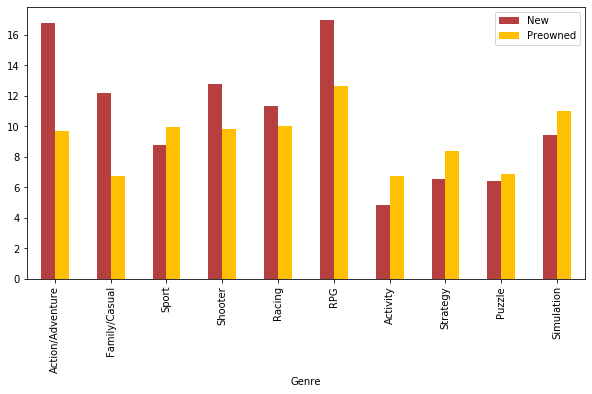

In [84]:
import matplotlib.pyplot as plt
plot =data.plot.bar(x='Genre', color =colors, figsize=(10,5))
fig = plot.get_figure()
fig.savefig('Genre.png',dpi=600,bbox_inches = "tight")

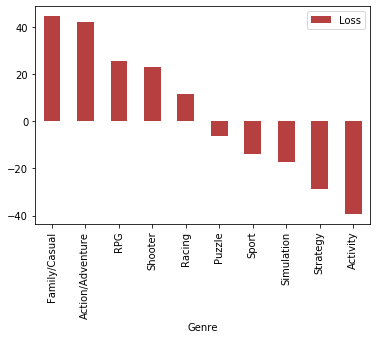

In [85]:
# Find the difference between new/pre and the avg per genre

data2 = pd.read_sql_query('select round(((New - Preowned)/New *100),2) as Loss, Genre from (select avg(New_Price) as New, avg(Preowned_Price) as Preowned, Genre from Game group by Genre) x group by Genre order by Loss DESC;', engine)
plot2 =data2.plot.bar(x='Genre', color=colors)
fig2 = plot2.get_figure()
fig2.savefig('Loss.png',dpi=600,bbox_inches = "tight")

In [46]:
data3 = pd.read_sql_query('select count(Name) as titles, Console from Game group by Console order by titles DESC limit 5;', engine)
data3.set_index('Console', inplace = True)
data3.rename(columns={'titles':'Titles'}, inplace=True)

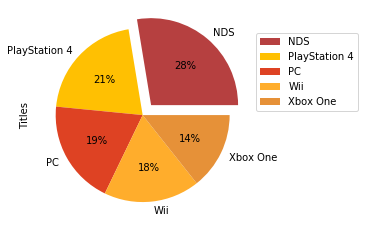

In [94]:
colors = ["#b64040", "#ffc002", "#de4223", "#ffad2c", "#e69138"]
plot3 = data3.plot.pie(y='Titles',autopct='%1.0f%%',explode=(0.15, 0, 0, 0, 0), colors = colors)
plot3.legend(loc='center left', bbox_to_anchor=(1, 0.7))
fig3= plot3.get_figure()
fig3.savefig('console.png', dpi=600,bbox_inches = "tight")

In [14]:
# Save file as csv
Game_df.to_csv('Game_df.csv', sep=' ', index=False)

Connect to MySQL and save as database

In [13]:
# import pymysql, and import create engine
# Create engine
engine = create_engine('mysql+pymysql://root:{}')
Game_df.to_sql(name='Game', con=engine, if_exists = 'append')


In [3]:
genre_list = []
genre_web_page_flat = []

def get_websites():
    # Get soup - and define url of genre website
    url = 'https://www.game.co.uk/en/games/?attributeName1=Release%20Date&sortColumn=popular&sortTypeStr=DESC&inStockOnly=true&listerOnly=true&attributeValue1=4294965823&sortBy='
    html = requests.get(url).content
    soup = BeautifulSoup(html,'lxml')
    # Get only genre list and #
    # div.genre a to select genre div. a has text of genre and span contains the number of games in that genre
    [genre_list.append(i.text.strip().replace('\xa0','.')) for i in soup.select('div.genre a')]
    # To find website forward links, save all numbers in url linked to genre page
    genre_web_page = [re.findall(r'2=(\d+)',i['href']) for i in soup.select('div.genre a')]
    # Turn web page numbers into ints
    for i in genre_web_page:
        for x in i:
            genre_web_page_flat.append(int(x))
get_websites()
print(genre_list)
print(genre_web_page)

['100.(1)', '3XL.(1)', 'Accessories.(359)', 'Action.(2)', 'Action/Adventure.(4,695)', 'Activity.(696)', 'Animation.(7)', 'Apple.(48)', 'Art Work.(1)', "Beat 'em up.(286)", 'Board Games.(6)', 'Building/Constr….(7)', 'Calendars; Annu….(6)', 'Children/Family.(18)', 'Classical.(3)', 'Collectables.(47)', 'Compilation.(5)', 'Computing.(12)', 'Console.(1)', 'Consoles.(136)', 'Controllers and….(1)', 'Crime.(5)', 'Dance.(28)', 'Digital Currency.(130)', 'Digital Subscri….(17)', 'Drama.(1)', 'Electronics.(18)', 'Family/Casual.(1,823)', 'Fiction.(1)', 'Fighting.(279)', 'Figurines & Sets.(189)', 'Fitness and Hea….(51)', 'Games.(2)', 'Gaming Credit.(1)', 'Gaming PC.(1)', 'Gift.(2)', 'Gift Vouchers.(1)', 'Gifts and Gadgets.(13)', 'Hardware.(18)', 'Horror.(195)', 'Interactive.(5)', 'Large.(2)', 'Medium.(1)', 'Merchandise.(222)', 'Music.(259)', 'Other.(33)', 'Party/Mini-Game.(35)', 'PC Accessories.(1)', 'Pinball.(1)', 'Puzzle.(591)', 'Racing.(1,049)', 'Role Playing.(64)', 'Role playing.(43)', 'Romance.